In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import sys
sys.path.insert(1, "C:/sers/jaege/PycharmProjects/labour-katharina");
from _katharina import contraction_features
import datetime
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [2]:
feature_names = ['count', 'duration_min', 'duration_max', 'duration_mean', 'duration_median', 'duration_quantile_1', 'duration_quantile_3', 'duration_sd', 'duration_maxmin', 'duration_rmssd',
                'timebetween_min', 'timebetween_max', 'timebetween_mean', 'timebetween_median', 'timebetween_quantile_1', 'timebetween_quantile_3', 'timebetween_sd', 'timebetween_maxmin', 'timebetween_rmssd']

# Edge values for NaNs 

In [3]:
features_sub20_1024 = pd.read_pickle('./data/edge/windowsize1024/features_sub20.pkl')
features_sub20_2048 = pd.read_pickle('./data/edge/windowsize2048/features_sub20.pkl')
features_sub20_3072 = pd.read_pickle('./data/edge/windowsize3072/features_sub20.pkl')

contractions = pd.read_pickle('./data/contractions.pkl')
users = pd.read_pickle('./data/users.pkl')
recordings = pd.read_pickle('./data/recordings.pkl')

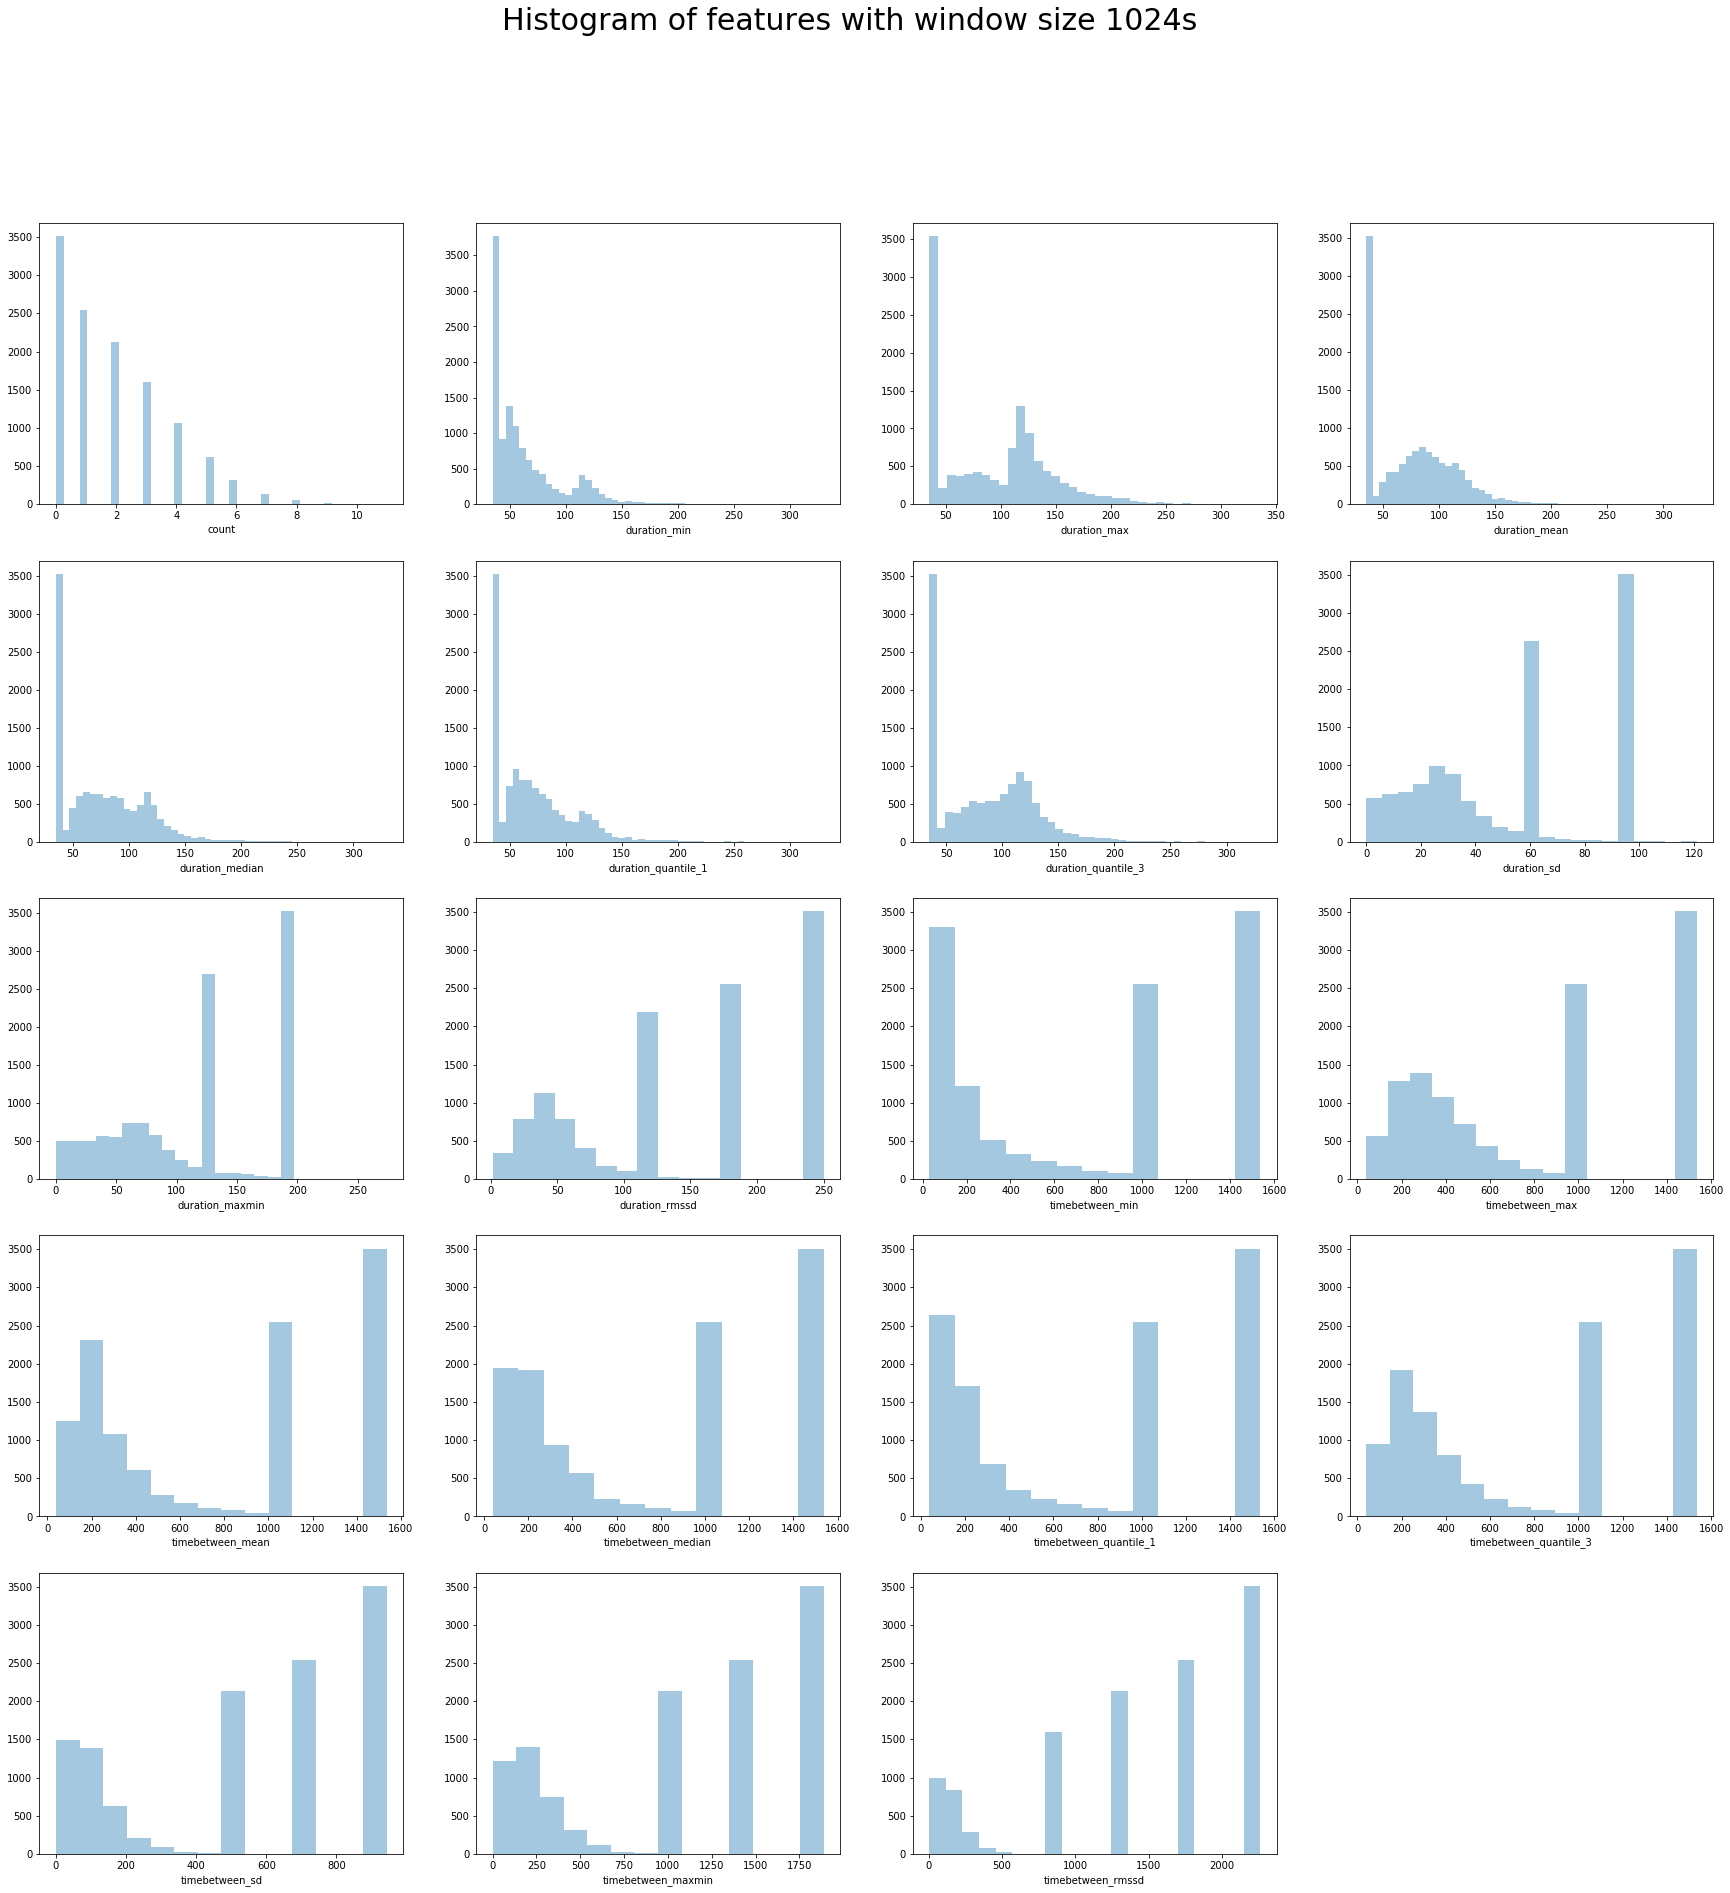

In [4]:
fig = plt.figure(figsize= (30,30))
fig.suptitle('Histogram of features with window size 1024s', fontsize=30)

for i, feature in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    sns.distplot(features_sub20_1024[feature], hist=True, kde=False)

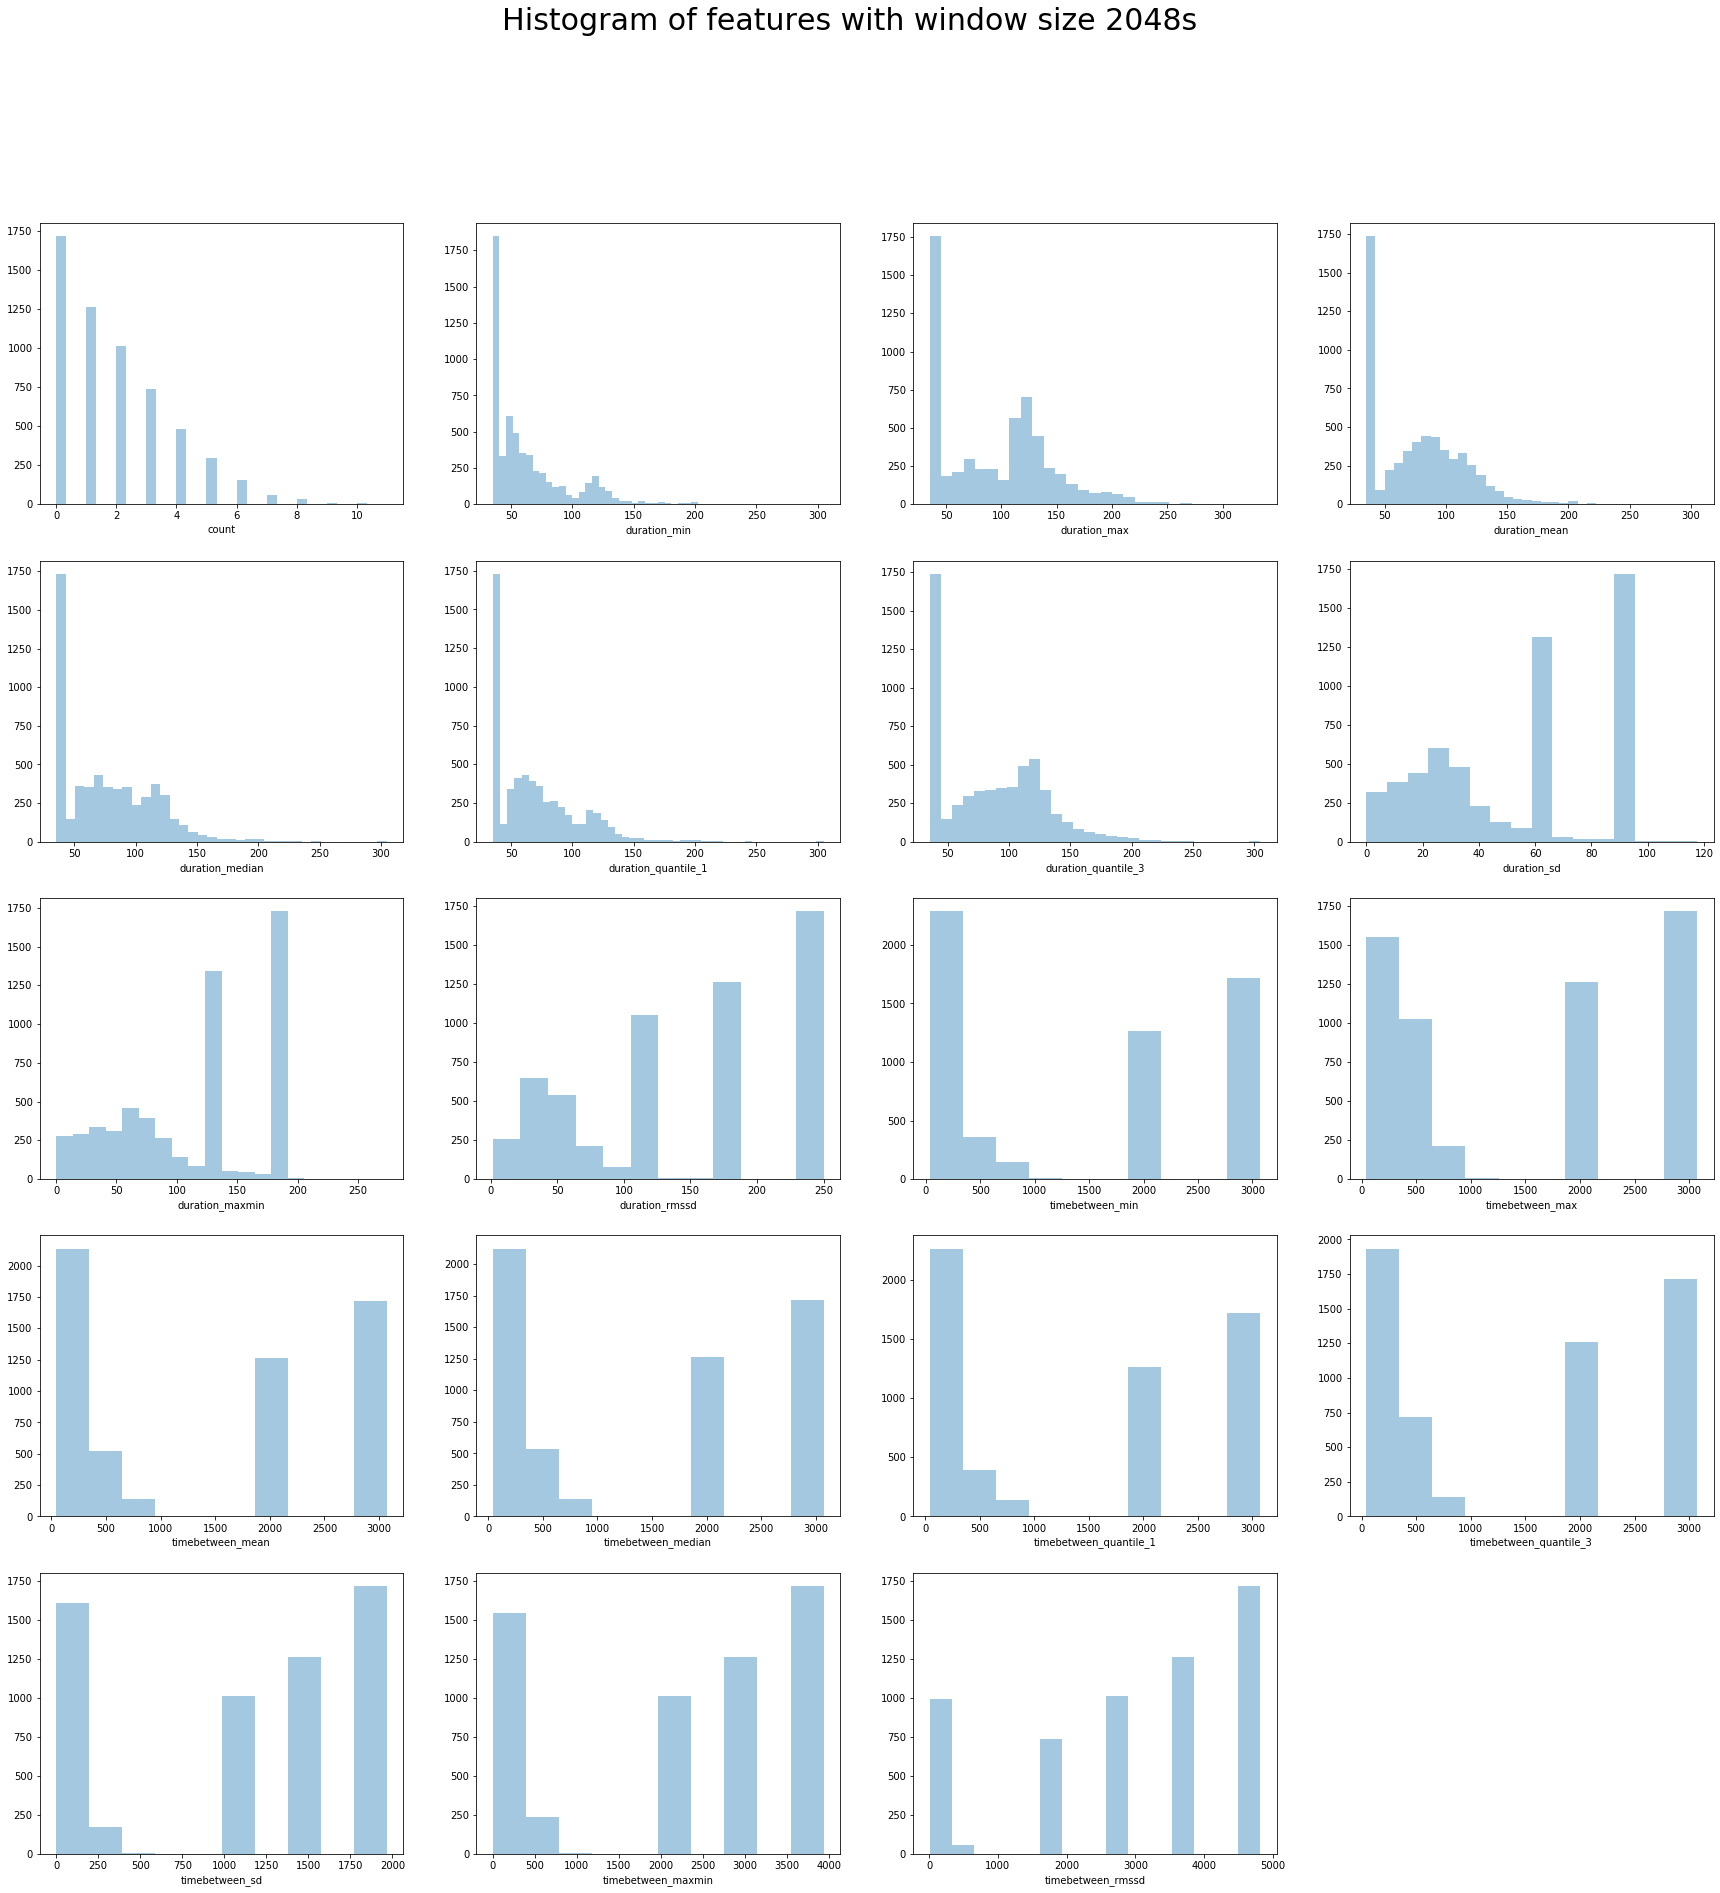

In [5]:
fig = plt.figure(figsize= (30,30))
fig.suptitle('Histogram of features with window size 2048s', fontsize=30)

for i, feature in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    sns.distplot(features_sub20_2048[feature], hist=True, kde=False)

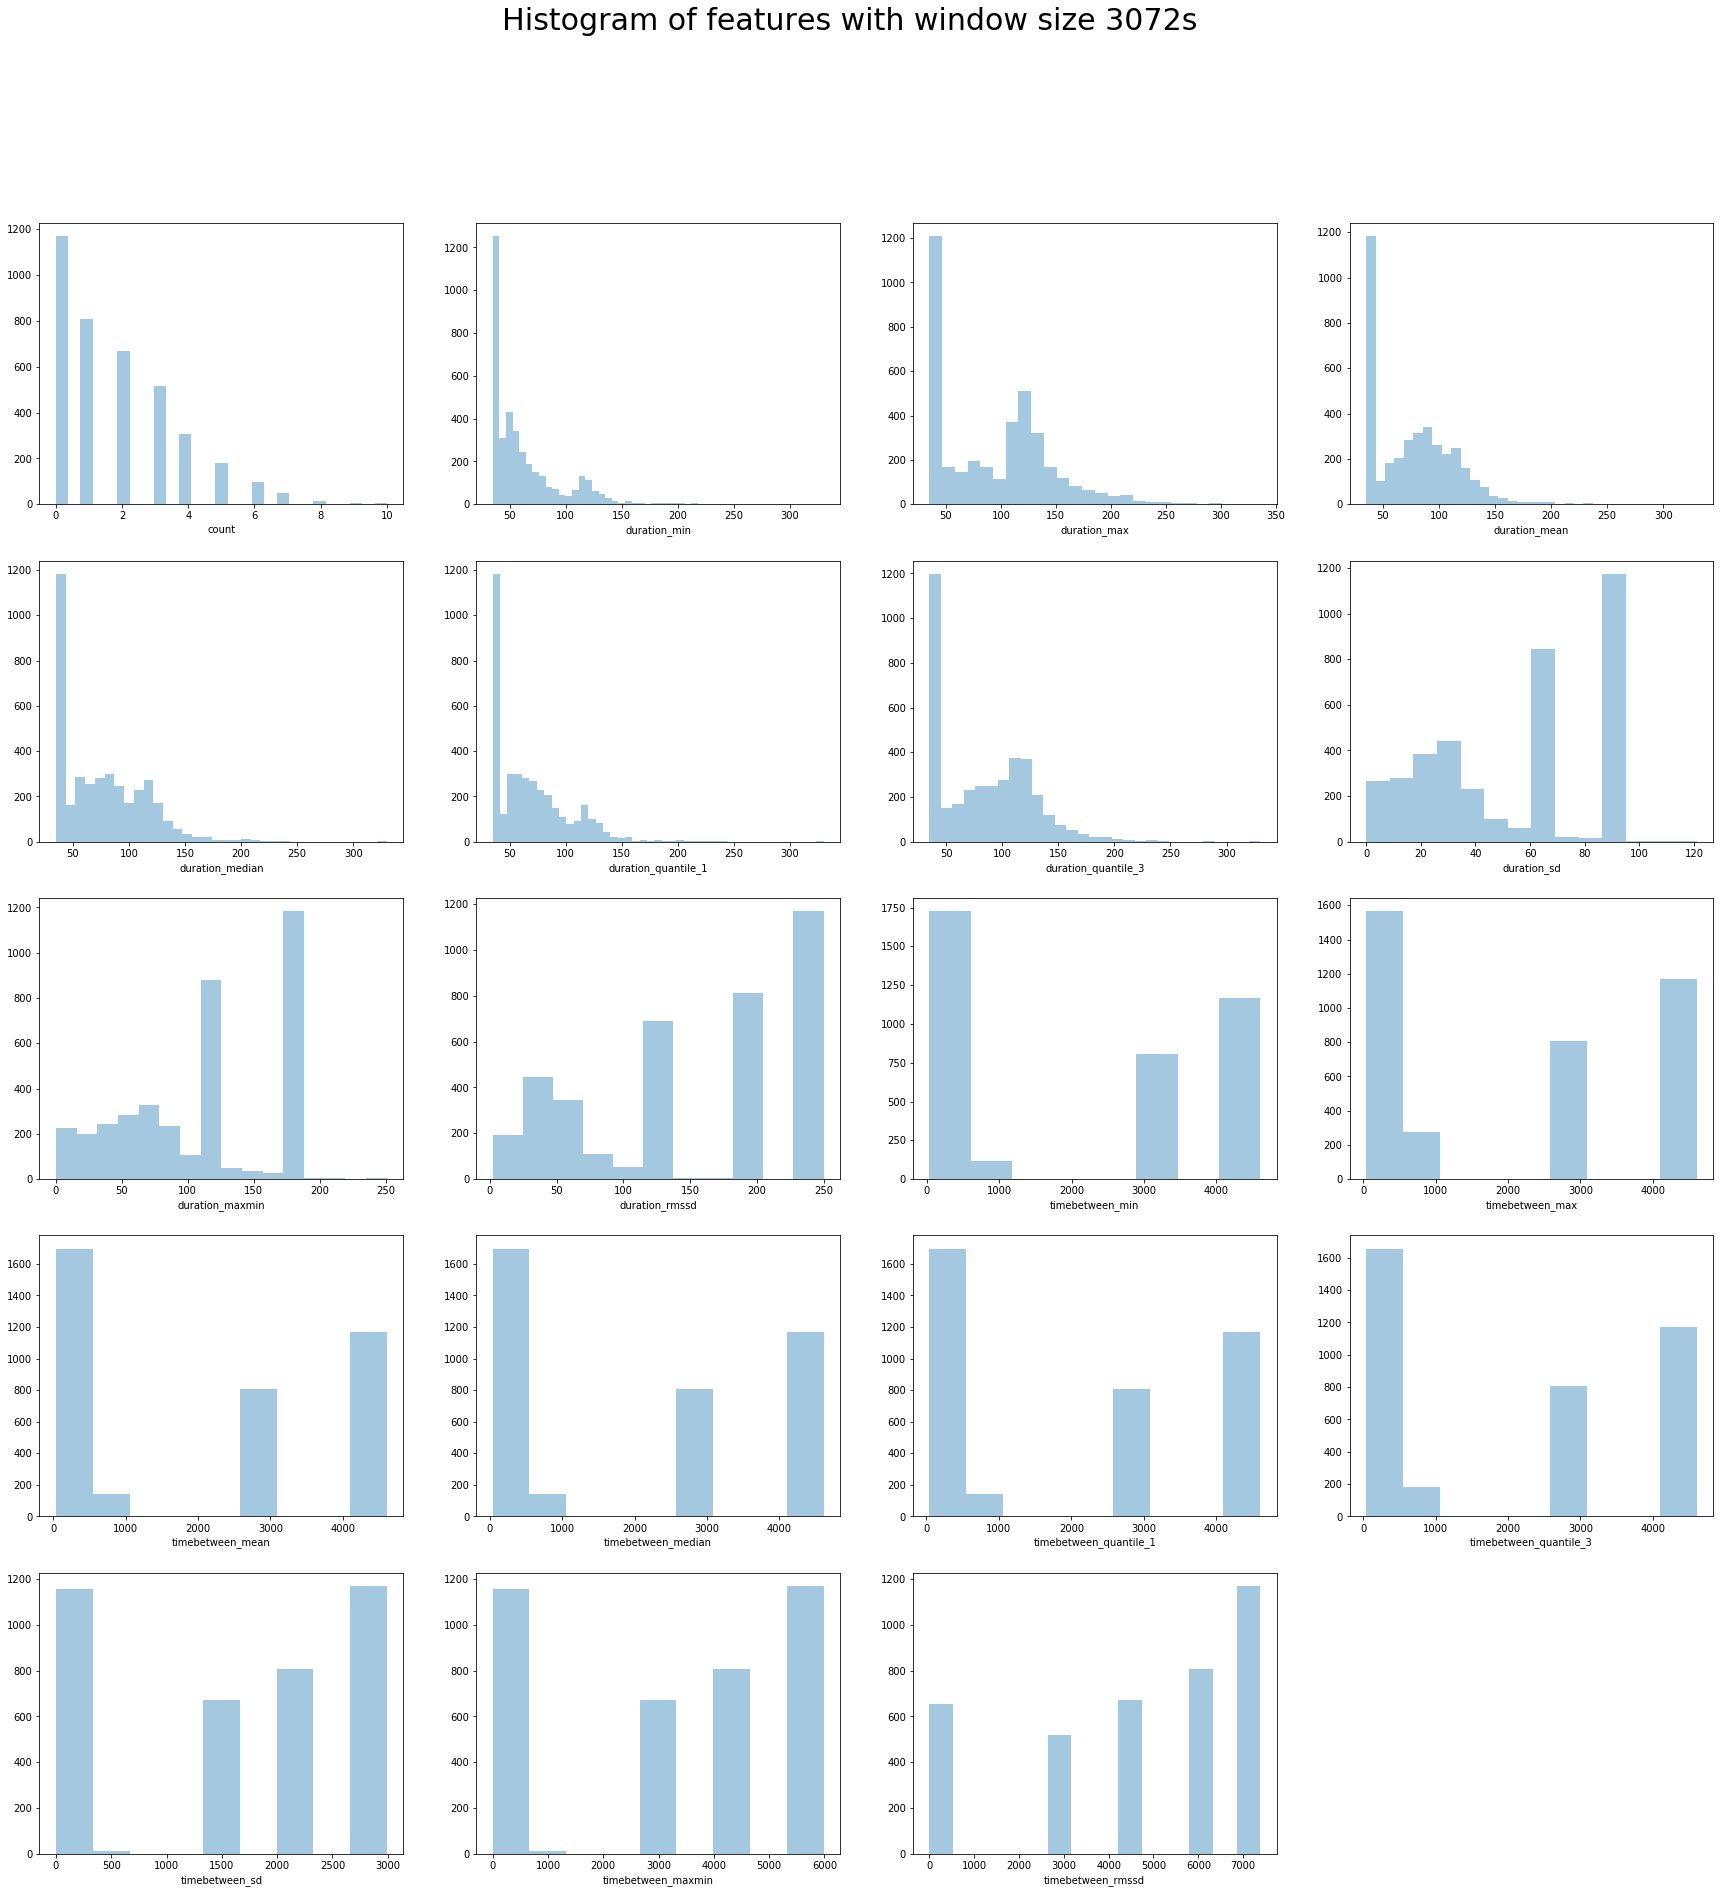

In [6]:
fig = plt.figure(figsize= (30,30))
fig.suptitle('Histogram of features with window size 3072s', fontsize=30)

for i, feature in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    sns.distplot(features_sub20_3072[feature], hist=True, kde=False)

### Histogram of features with window sizes 1024s, 2048s and 3072s

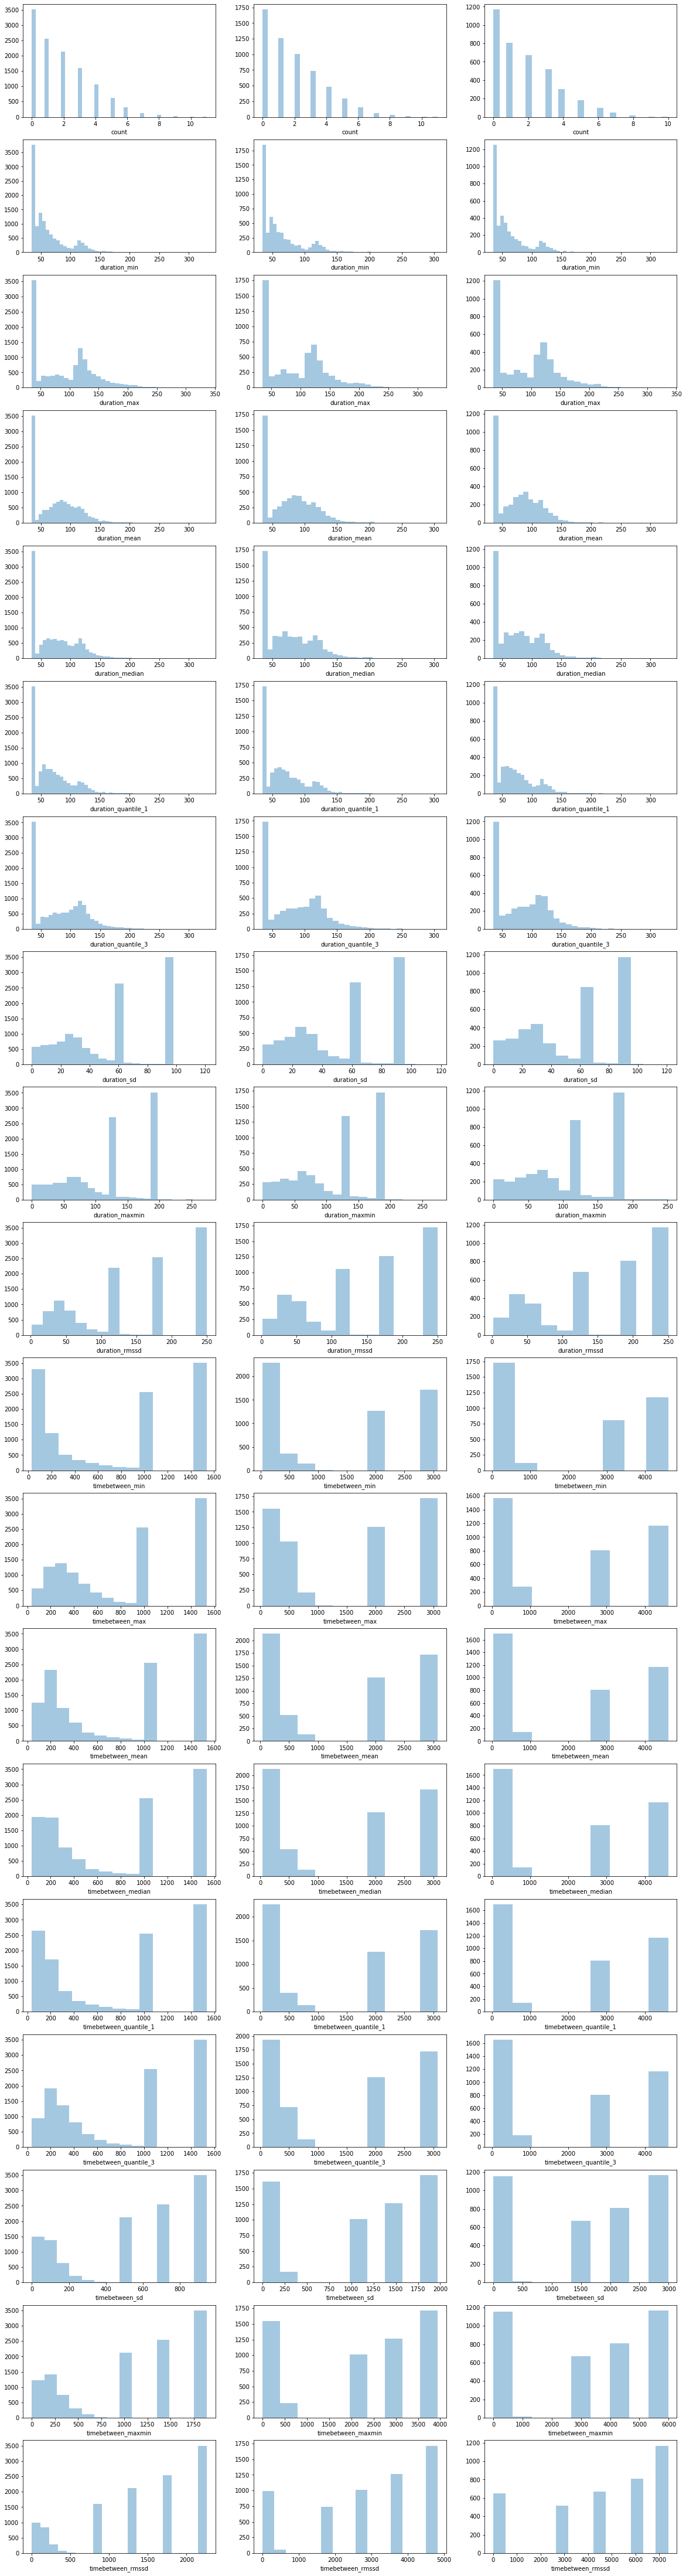

In [7]:
# plot 3 window sizes next to each other for each feature + same scale
fig = plt.figure(figsize= (20,80))
#fig.title('Histogram of features with window size 3072s', fontsize=30)
for i, feature in enumerate(feature_names):
    ax = plt.subplot(19,3,3*i+1)
    sns.distplot(features_sub20_1024[feature], hist=True, kde=False)
   # ax.set_title('Window size 1024')
    ax = plt.subplot(19,3,3*i+2)
    sns.distplot(features_sub20_2048[feature], hist=True, kde=False)
   # ax.set_title('Window size 2048')
    ax = plt.subplot(19,3,3*i+3)
    sns.distplot(features_sub20_3072[feature], hist=True, kde=False)
    #ax.set_title('Window size 3072')

#### Notch in contraction duration distribution 

Found out that there exist many contractions that last much longer than 2:40min (intern threshold). 
Distribution of contraction duration has a notch at around 110.
Reason for this notch could be 
- labor vs. non-labor
- artifact induced vs. non-artifact
- ...?

First check labor vs. non-labor. This is not the reason for the noth, because in both distribution still present.
Then: 
- investigate if artifact is origin of notch
- remove artifact based contractions

Otherwise remove all contractions after notch

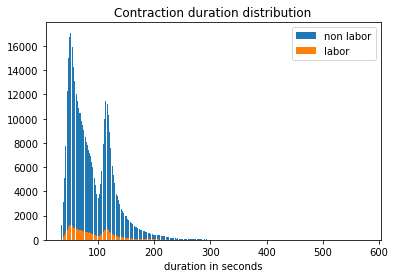

In [8]:
durs = contractions[contractions['labor'] == 0]['duration'].dt.total_seconds()
x, count = np.unique(durs, return_counts=True);
plt.bar(x, count, color='C0', label='non labor')
plt.xlabel('duration in seconds')

durs = contractions[contractions['labor'] == 1]['duration'].dt.total_seconds()
x, count = np.unique(durs, return_counts=True);
plt.bar(x, count, color='C1', label='labor')
plt.xlabel('duration in seconds')
plt.legend()
plt.title('Contraction duration distribution');



baseline over ExG over last 2 mins;
shift in baseline due to noise etc -> baseline shift (remove baseline)
but after 2mins it will drop again -> this is detected as contractions

# No edge values

In [9]:
features_sub20_1024 = pd.read_pickle('./data/noEdge/windowsize1024/features_sub20.pkl')
#features_sub20_2048 = pd.read_pickle('./data/noEdge/windowsize2048/features_sub20.pkl')
#features_sub20_3072 = pd.read_pickle('./data/noEdge/windowsize3072/features_sub20.pkl')

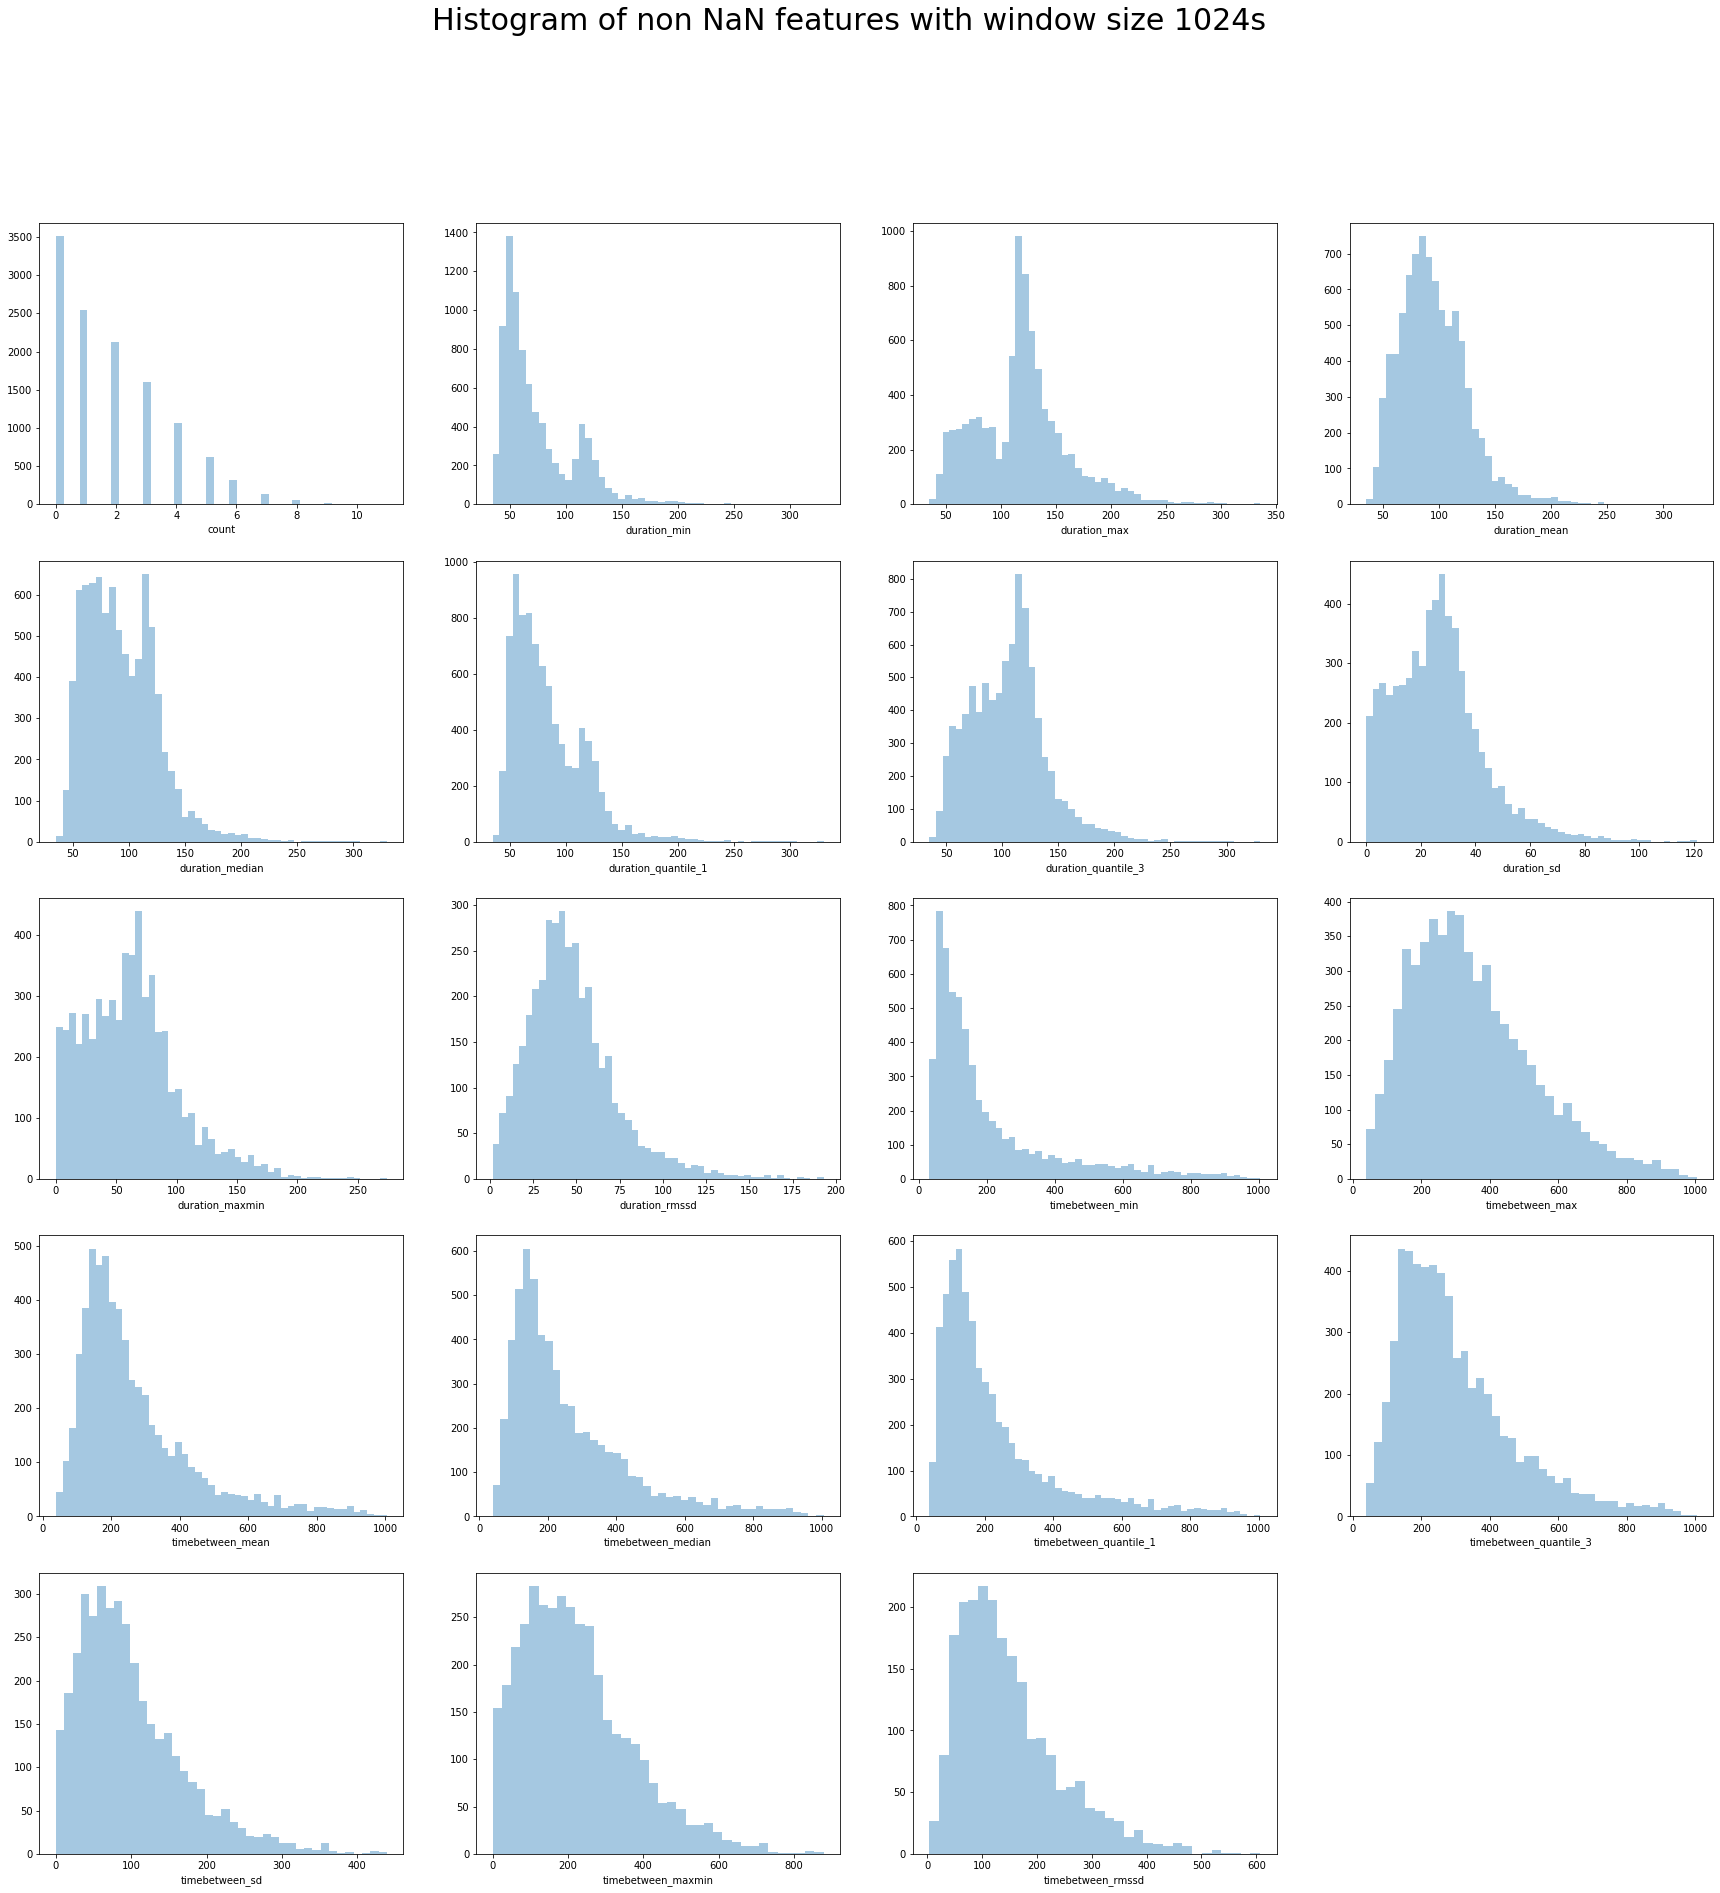

In [10]:
# plot histogram with dropped nans
# plot boxplot
fig = plt.figure(figsize= (30,30))
fig.suptitle('Histogram of non NaN features with window size 1024s', fontsize=30)

for i, feature in enumerate(feature_names):
    f = features_sub20_1024[feature].dropna()
    ax = plt.subplot(5,4,i+1)
    sns.distplot(f, hist=True, kde=False)

In [11]:

features_sub20_1024


count  duration_min  duration_max  duration_mean  duration_median  \
0         1          56.0          56.0      56.000000             56.0   
1         0           NaN           NaN            NaN              NaN   
2         0           NaN           NaN            NaN              NaN   
3         0           NaN           NaN            NaN              NaN   
4         1         111.0         111.0     111.000000            111.0   
5         1         193.0         193.0     193.000000            193.0   
6         1         201.0         201.0     201.000000            201.0   
7         1         115.0         115.0     115.000000            115.0   
8         0           NaN           NaN            NaN              NaN   
9         0           NaN           NaN            NaN              NaN   
10        1          67.0          67.0      67.000000             67.0   
11        1         125.0         125.0     125.000000            125.0   
12        2          83.0         140.0     111.500000            111.5   
13        5          48.0          96.0      67.600000             59.0   
14        3          59.0          89.0      71.666667             67.0   
15        2          56.0          63.0      59.500000             59.5   
16        1          76.0          76.0      76.000000             76.0   
17        0           NaN           NaN            NaN              NaN   
18        0           NaN           NaN            NaN              NaN   
19        0           NaN           NaN            NaN              NaN   
20        0           NaN           NaN            NaN              NaN   
21        1         113.0         113.0     113.000000            113.0   
22        1          51.0          51.0      51.000000             51.0   
23        6          38.0         144.0      82.333333             70.5   
24        3          51.0         112.0      72.000000             53.0   
25        2          74.0          84.0      79.000000             79.0   
26        2          49.0          81.0      65.000000             65.0   
27        4          43.0          95.0      66.000000             63.0   
28        1          92.0          92.0      92.000000             92.0   
29        1         116.0         116.0     116.000000            116.0   
...     ...           ...           ...            ...              ...   
11980     0           NaN           NaN            NaN              NaN   
11981     0           NaN           NaN            NaN              NaN   
11982     0           NaN           NaN            NaN              NaN   
11983     0           NaN           NaN            NaN              NaN   
11984     0           NaN           NaN            NaN              NaN   
11985     0           NaN           NaN            NaN              NaN   
11986     0           NaN           NaN            NaN              NaN   
11987     0           NaN           NaN            NaN              NaN   
11988     0           NaN           NaN            NaN              NaN   
11989     0           NaN           NaN            NaN              NaN   
11990     0           NaN           NaN            NaN              NaN   
11991     0           NaN           NaN            NaN              NaN   
11992     0           NaN           NaN            NaN              NaN   
11993     1          54.0          54.0      54.000000             54.0   
11994     0           NaN           NaN            NaN              NaN   
11995     0           NaN           NaN            NaN              NaN   
11996     0           NaN           NaN            NaN              NaN   
11997     1          56.0          56.0      56.000000             56.0   
11998     0           NaN           NaN            NaN              NaN   
11999     1          48.0          48.0      48.000000             48.0   
12000     1          60.0          60.0      60.000000             60.0   
12001     0           NaN      